Raw shape: (1370775, 42)
After filtering to 2013-14+ seasons: 1370775 rows
After dropping missing core columns: (1358485, 42)
Train set: 997229 | Holdout set: 360751

Random search for combined model (GPU, raw xG) ...
Trial 1/20, Score: -0.2016
Trial 2/20, Score: -0.2041
Trial 3/20, Score: -0.2009
Trial 4/20, Score: -0.2014
Trial 5/20, Score: -0.2086
Trial 6/20, Score: -0.2022
Trial 7/20, Score: -0.2074
Trial 8/20, Score: -0.2045
Trial 9/20, Score: -0.2015
Trial 10/20, Score: -0.2014
Trial 11/20, Score: -0.2058
Trial 12/20, Score: -0.2012
Trial 13/20, Score: -0.2053
Trial 14/20, Score: -0.2249
Trial 15/20, Score: -0.2059
Trial 16/20, Score: -0.2001
Trial 17/20, Score: -0.2138
Trial 18/20, Score: -0.2026
Trial 19/20, Score: -0.2014
Trial 20/20, Score: -0.2016

Best hyperparameters found: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'use_label_encoder': False, 'random_state': 42, 'tree_method': 'gpu_hist', 'max_depth': 8, 'learning_rate': 0.012657482516546224, 'n_estimators

c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:23:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:23:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:2676: UserWarning: [17:23:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to C


=== Combined Holdout (Raw xG) ===
LogLoss: 0.2087 | AUC: 0.7994 | Brier Score: 0.0576

Final combined model (GPU, Random Search) trained and holdout evaluated!


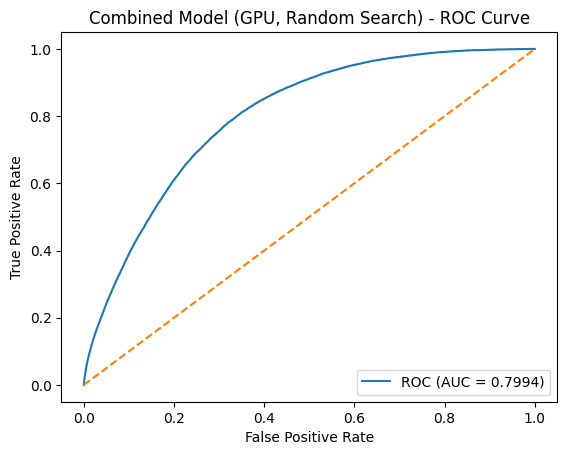

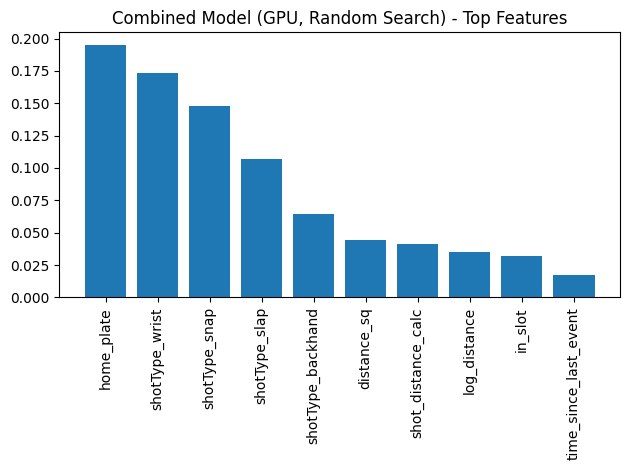

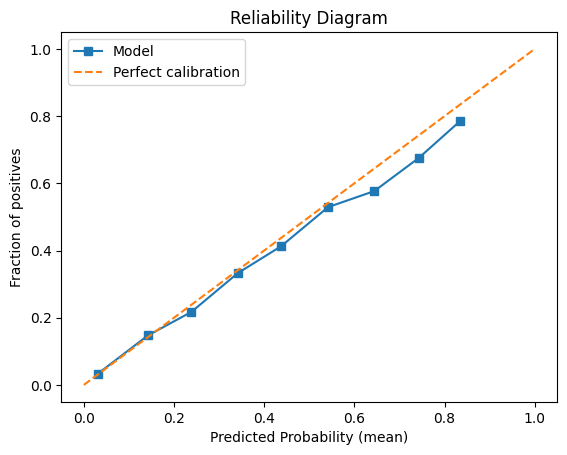


Sample holdout xG predictions:
         shot_made        xG
1009774          0  0.004543
1009775          0  0.239137
1009776          0  0.007598
1009777          0  0.010253
1009778          0  0.145856
1009779          1  0.122814
1009780          0  0.013619
1009781          0  0.265267
1009782          0  0.006683
1009783          0  0.003167
All done!


In [ ]:
#!/usr/bin/env python
# ---------------------------------------------------------------------------
#  Hockey xG Pipeline — CSV Version
# ---------------------------------------------------------------------------
import numpy as np
import pandas as pd
import pickle
import random
import math

# For modeling and evaluation
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    roc_curve, auc, log_loss, precision_score,
    recall_score, f1_score, roc_auc_score
)
from sklearn.calibration import calibration_curve

import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Imbalanced-learn pipeline (no oversampling)
from imblearn.pipeline import Pipeline as ImbPipeline

# ----------------- GLOBAL SETTINGS -----------------
HOLDOUT_SEASONS = [20222023, 20232024, 20242025]  # last 3 seasons
CSV_PATH = "data/xg_table.csv.gz"                  # compressed dataset

# ---------------------------------------------------
#                 UTILITY FUNCTIONS
# ---------------------------------------------------
def time_to_seconds(t_str):
    try:
        mm, ss = t_str.split(':')
        return int(mm) * 60 + int(ss)
    except Exception:
        return np.nan

def add_prior_event_features(df):
    df = df.copy()
    df["current_time_s"] = df["time_in_period"].apply(time_to_seconds)
    df["prev_time_s"] = df["prev_event_time"].apply(time_to_seconds)

    same_period = df["period_number"] == df["prev_event_period"]
    df["time_since_last_event"] = np.where(
        same_period,
        df["current_time_s"] - df["prev_time_s"],
        np.nan,
    )

    valid_coords = (
        same_period
        & df[["xCoord", "yCoord", "prev_event_x", "prev_event_y"]].notnull().all(axis=1)
    )
    df["distance_from_last_event"] = np.where(
        valid_coords,
        np.sqrt(
            (df["xCoord"] - df["prev_event_x"]) ** 2
            + (df["yCoord"] - df["prev_event_y"]) ** 2
        ),
        np.nan,
    )

    df["delta_x"] = np.where(valid_coords, df["xCoord"] - df["prev_event_x"], np.nan)
    df["delta_y"] = np.where(valid_coords, df["yCoord"] - df["prev_event_y"], np.nan)

    df["movement_angle"] = np.degrees(np.arctan2(df["delta_y"], df["delta_x"]))
    df["movement_speed"] = df["distance_from_last_event"] / df["time_since_last_event"]
    return df

def clean_and_calculate_coords(df):
    df = df.copy()
    mask = df["xCoord"] < 0
    df.loc[mask, "xCoord"] = -df.loc[mask, "xCoord"]
    df.loc[mask, "yCoord"] = -df.loc[mask, "yCoord"]

    df = df[(df["xCoord"].between(-99, 99)) & (df["yCoord"].between(-42, 42))]
    df = df.dropna(subset=["xCoord", "yCoord"])

    x_abs = df["xCoord"].abs()
    df["shot_distance_calc"] = np.sqrt((89 - x_abs) ** 2 + df["yCoord"] ** 2)
    df["shot_angle_signed"] = np.degrees(
        np.arctan2(df["yCoord"], (89 - df["xCoord"]))
    )
    df["shot_angle_calc"] = df["shot_angle_signed"]
    return df

def compute_binned_score_diff(row):
    diff = row.get("homeScore", 0) - row.get("awayScore", 0)
    if diff <= -2:
        return "down2+"
    elif diff == -1:
        return "down1"
    elif diff == 0:
        return "tie"
    elif diff == 1:
        return "up1"
    else:
        return "up2+"

def point_in_polygon(x, y, polygon):
    num_points = len(polygon)
    inside = False
    p1x, p1y = polygon[0]
    for i in range(num_points + 1):
        p2x, p2y = polygon[i % num_points]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    xinters = (
                        (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                        if p1y != p2y
                        else p1x
                    )
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

# ---------------------------------------------------
#      BUILD FEATURE MATRIX (One-Hot for 4 shotTypes)
# ---------------------------------------------------
def build_feature_matrix(df):
    df = df.copy()
    y = df["shot_made"].astype(int)

    numeric_cols = [
        "shot_distance_calc",
        "shot_angle_calc",
        "is_forward",
        "time_since_last_event",
        "distance_from_last_event",
        "delta_x",
        "delta_y",
        "movement_angle",
        "movement_speed",
    ]
    for col in numeric_cols:
        if col not in df.columns:
            df[col] = 0

    X_num = df[numeric_cols].fillna(0)

    # Non-linear transforms
    X_num["distance_sq"] = X_num["shot_distance_calc"] ** 2
    X_num["log_distance"] = np.log1p(X_num["shot_distance_calc"])
    X_num["angle_sq"] = X_num["shot_angle_calc"] ** 2
    X_num["dist_x_angle"] = X_num["shot_distance_calc"] * X_num["shot_angle_calc"]

    # Cross-terms & higher-order
    X_num["movement_speed_sq"] = X_num["movement_speed"] ** 2
    X_num["time_since_last_event_sq"] = X_num["time_since_last_event"] ** 2
    X_num["dist_x_speed"] = X_num["shot_distance_calc"] * X_num["movement_speed"]

    # Distance bin
    bins = [0, 10, 20, 30, 50, 200]
    labels = [1, 2, 3, 4, 5]
    X_num["dist_bin"] = (
        pd.cut(
            X_num["shot_distance_calc"],
            bins=bins,
            labels=labels,
        )
        .astype(float)
        .fillna(0)
    )

    # "Slot" indicator
    X_num["in_slot"] = np.where(
        (X_num["shot_distance_calc"] < 25) & (X_num["shot_angle_calc"].abs() < 30),
        1,
        0,
    )

    # behind_net indicator
    X_num["behind_net"] = np.where(
        (df["xCoord"] > 89) | (df["xCoord"] < -89),
        1,
        0,
    )

    # Radial distance & "home plate"
    X_num["radial_distance"] = df["yCoord"].abs()
    home_plate_polygon = [(89, -3.5), (89, 3.5), (69, 22), (52, 0), (69, -22)]
    X_num["home_plate"] = [
        int(point_in_polygon(x, y, home_plate_polygon))
        for x, y in zip(df["xCoord"], df["yCoord"])
    ]

    # Period & time fraction
    X_num["period"] = df.get("period_number", 0).fillna(0).astype(int)

    if "time_in_period" in df.columns:
        df["time_s"] = df["time_in_period"].apply(time_to_seconds)
        X_num["time_fraction"] = (df["time_s"] / 1200).clip(0, 1)
    else:
        X_num["time_fraction"] = 0.0

    # Score diff dummies
    df["homeScore"] = df.get("homeScore", 0)
    df["awayScore"] = df.get("awayScore", 0)
    df["score_diff_cat"] = df.apply(compute_binned_score_diff, axis=1)
    score_diff_dummies = pd.get_dummies(df["score_diff_cat"], prefix="scoreDiff")

    # Shot-type one-hots
    valid_shot_types = ["wrist", "snap", "slap", "backhand"]
    filtered_shotType = (
        df["shotType"].where(df["shotType"].isin(valid_shot_types), np.nan)
        if "shotType" in df.columns
        else pd.Series(dtype=str)
    )
    shot_type_dummies = pd.get_dummies(filtered_shotType, prefix="shotType")

    # Combine everything
    X = pd.concat([X_num, score_diff_dummies, shot_type_dummies], axis=1)
    return X, y

# ---------------------------------------------------
#     RANDOM SEARCH (GPU, no threshold)
# ---------------------------------------------------
def random_search_xgb_gpu(X, y, n_trials=20, random_state=42):
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)
    best_score = -np.inf
    best_params = None

    for i in range(n_trials):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "use_label_encoder": False,
            "random_state": random_state,
            "tree_method": "gpu_hist",
            "max_depth": np.random.randint(2, 11),
            "learning_rate": math.exp(
                np.random.uniform(math.log(0.005), math.log(0.3))
            ),
            "n_estimators": np.random.randint(50, 601),
            "subsample": np.random.uniform(0.3, 1.0),
            "colsample_bytree": np.random.uniform(0.3, 1.0),
            "min_child_weight": np.random.randint(1, 51),
            "reg_alpha": np.random.uniform(0.0, 1.0),
            "reg_lambda": np.random.uniform(0.5, 3.0),
            "gamma": np.random.uniform(0.0, 5.0),
        }
        pipeline = ImbPipeline([("xgb", XGBClassifier(**params))])
        scores = cross_val_score(
            pipeline,
            X,
            y,
            scoring="neg_log_loss",
            cv=skf,
            n_jobs=-1,
        )
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            best_params = params

        print(f"Trial {i+1}/{n_trials}, Score: {mean_score:.4f}")

    print("\nBest hyperparameters found:", best_params)
    final_pipeline = ImbPipeline([("xgb", XGBClassifier(**best_params))])
    final_pipeline.fit(X, y)
    return final_pipeline

# ---------------------------------------------------
#     MAIN TRAINING / MODEL BUILDING
# ---------------------------------------------------
def xg_model_combined_gpu_random():
    # 1) Load compressed CSV
    df = pd.read_csv(CSV_PATH, compression="gzip")
    print("Raw shape:", df.shape)

    # 2) Standard data cleaning
    df = df[df["season"] >= 20132014]
    print(f"After filtering to 2013-14+ seasons: {len(df)} rows")

    df = df.dropna(subset=["shot_made", "situation_code", "time_in_period"])
    print("After dropping missing core columns:", df.shape)

    df = clean_and_calculate_coords(df)
    df = add_prior_event_features(df)

    df_train = df[~df["season"].isin(HOLDOUT_SEASONS)].copy()
    df_holdout = df[df["season"].isin(HOLDOUT_SEASONS)].copy()
    print(f"Train set: {len(df_train)} | Holdout set: {len(df_holdout)}")

    X_train, y_train = build_feature_matrix(df_train)
    X_hold, y_hold = build_feature_matrix(df_holdout)
    X_hold = X_hold.reindex(columns=X_train.columns, fill_value=0)

    print("\nRandom search for combined model (GPU, raw xG) ...")
    final_model = random_search_xgb_gpu(
        X_train, y_train, n_trials=20, random_state=42
    )

    df_holdout["xG"] = np.nan
    if len(df_holdout) > 0:
        probs = final_model.predict_proba(X_hold)[:, 1]
        df_holdout["xG"] = probs

        ll = log_loss(y_hold, probs)
        auc_val = roc_auc_score(y_hold, probs)
        brier_score = np.mean((probs - y_hold) ** 2)

        print("\n=== Combined Holdout (Raw xG) ===")
        print(f"LogLoss: {ll:.4f} | AUC: {auc_val:.4f} | Brier: {brier_score:.4f}")

    with open("xgb_combined_gpu_random.pkl", "wb") as f:
        pickle.dump(final_model, f)

    print("\nFinal combined model saved!")
    return final_model, X_hold, y_hold, df_holdout

# ---------------------------------------------------
#     PLOTTING FUNCTIONS
# ---------------------------------------------------
def plot_roc_curve(model, X_hold, y_hold):
    if X_hold is None or y_hold is None or len(X_hold) == 0:
        print("No holdout data to plot.")
        return

    probs = model.predict_proba(X_hold)[:, 1]
    fpr, tpr, _ = roc_curve(y_hold, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title("Combined Model (GPU) – ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

def plot_feature_importances(model, top_n=10):
    xgb_model = model["xgb"]
    importances = xgb_model.feature_importances_
    feature_names = xgb_model.get_booster().feature_names

    idx_sorted = np.argsort(importances)[::-1]
    sorted_importances = importances[idx_sorted]
    sorted_features = [feature_names[i] for i in idx_sorted]

    plt.figure()
    plt.bar(range(top_n), sorted_importances[:top_n])
    plt.xticks(range(top_n), sorted_features[:top_n], rotation=90)
    plt.title("Combined Model – Top Features")
    plt.tight_layout()
    plt.show()

def plot_reliability_diagram(model, X_hold, y_hold, n_bins=10):
    if X_hold is None or y_hold is None or len(X_hold) == 0:
        print("No holdout data for reliability diagram.")
        return

    probs = model.predict_proba(X_hold)[:, 1]
    fop, mpv = calibration_curve(y_hold, probs, n_bins=n_bins, strategy="uniform")

    plt.figure()
    plt.plot(mpv, fop, "s-", label="Model")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
    plt.title("Reliability Diagram")
    plt.xlabel("Predicted Probability (mean)")
    plt.ylabel("Fraction of positives")
    plt.legend(loc="best")
    plt.show()

# ---------------------------------------------------*
#                     Entry point
# ---------------------------------------------------
if __name__ == "__main__":
    final_model, X_hold, y_hold, df_holdout = xg_model_combined_gpu_random()

    plot_roc_curve(final_model, X_hold, y_hold)
    plot_feature_importances(final_model, top_n=10)
    plot_reliability_diagram(final_model, X_hold, y_hold, n_bins=10)

    print("\nSample holdout xG predictions:")
    print(df_holdout[["shot_made", "xG"]].head(10))
    print("All done!")
